In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [2]:
#loading in the merged dataframes
df_trump   = pd.read_csv('merged_trump.csv',   parse_dates=['thread_time_utc','comment_time_utc'])
df_melania = pd.read_csv('merged_melania.csv', parse_dates=['thread_time_utc','comment_time_utc'])
df_libra   = pd.read_csv('merged_libra.csv',   parse_dates=['thread_time_utc','comment_time_utc'])

In [3]:
#cleaning the data

#creating a new column 'full_text'
#remiving any extra spaces in the text
for df in [df_trump, df_melania, df_libra]:
    df["full_text"] = df["thread_title"].fillna('') + " " + df["comment_text"].fillna('')
    df['full_text'] = (df['full_text'].str.replace(r'\s+', ' ', regex=True).str.strip())

#dropping the 'url' column
for df in [df_trump, df_melania, df_libra]:
    if 'thread_url' in df.columns:
        df.drop(columns='thread_url', inplace=True)
        
#cutting of data after 2025-02-28
cutoff = pd.to_datetime('2025-02-28')   
for df in (df_trump, df_melania, df_libra):
    df.drop(df[df['comment_time_utc'] > cutoff].index, inplace=True)



In [4]:
#defining fomo and hype regex dictionaries
FOMO_PATTERNS = [
    r'\bnext \$\w+\b',                    # “next $COIN”
    r'\bnot financial advice\b',          # “not financial advice…”
    r'\byolo\b',                          # “YOLO”
    r'\ball in\b',                        # "I'm all in”
    r'\bdiamond hands\b',                 # “diamond hands” (hold through dips)
    r'\blast chance\b',                   # “last chance to buy”
    r'\bdon(\'t| not) miss (this|out)\b', # “don’t miss this/out”
    r'\bget rich quick\b',                # “get rich quick”
    r'\bget in before it(\'s)? too late\b', # “get in before it’s too late”
    r'\bmoonshot\b',                      # “moonshot” 
    r'\b\d+?x\b',                         # “100x”, “10x”
]
HYPE_PATTERNS = [
    r'\bexploding\b',                     # “exploding”
    r'\beveryone(\'s)? buying\b',         # “everyone’s buying”
    r'\bjoin (?:telegram|discord)\b',     # “join Telegram/Discord”
    r'\bgoing viral\b',                   # “going viral”
    r'\bto the moon\b',                   # “to the moon”
    r'\bmoon incoming\b',                 # “moon incoming”
    r'\bpump and dump\b',                 # “pump and dump”
    r'\bexplosive growth\b',              # “explosive growth”
    r'\bviral\b',                         # “viral”
    r'\bshill(ed)?\b',                    # “shill” / “shilled”
]


In [5]:
#safeguard against non-strings
def tag_terms(text, patterns):
    text = text if isinstance(text, str) else ''      
    return int(any(re.search(p, text, flags=re.IGNORECASE) for p in patterns))

#enriching the dataframes with fomo and hype flags
def enrich_hype_fomo(df):
    df = df.copy()
    #filling any missing full_text with '' and cast to str
    df['full_text'] = df['full_text'].fillna('').astype(str)
    df['fomo_flag'] = df['full_text'].map(lambda x: tag_terms(x, FOMO_PATTERNS))
    df['hype_flag'] = df['full_text'].map(lambda x: tag_terms(x, HYPE_PATTERNS))
    return df

#applying the fomo and hype flags to the dataframes
df_trump   = enrich_hype_fomo(df_trump)
df_melania = enrich_hype_fomo(df_melania)
df_libra   = enrich_hype_fomo(df_libra)

In [6]:
#burst detection over time function
#group the comments by hour
def detect_hype_fomo(df, freq='H', window=24, z_thresh=2):
    ts = df.set_index('comment_time_utc').sort_index()
    #count how many fomo and hype flags are in each hour
    agg = ts.resample(freq).agg({
        'fomo_flag': 'sum',
        'hype_flag': 'sum',
    })
    #comparing z-scores to the previous 24 hours
    agg['fomo_z'] = (agg['fomo_flag'] - agg['fomo_flag'].rolling(window).mean()) / agg['fomo_flag'].rolling(window).std()
    agg['hype_z'] = (agg['hype_flag'] - agg['hype_flag'].rolling(window).mean()) / agg['hype_flag'].rolling(window).std()
    #marking the spikes
    #if the z-score is greater than the threshold, mark it as a spike (1), else (0)
    agg['fomo_spike'] = (agg['fomo_z'] > z_thresh).astype(int)
    agg['hype_wave'] = (agg['hype_z'] > z_thresh).astype(int)
    return agg

#applying the burst detection to the dataframes
hype_trump   = detect_hype_fomo(df_trump)
hype_melania = detect_hype_fomo(df_melania)
hype_libra   = detect_hype_fomo(df_libra)


/tmp/ipykernel_2622090/2532872801.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  agg = ts.resample(freq).agg({
/tmp/ipykernel_2622090/2532872801.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  agg = ts.resample(freq).agg({
/tmp/ipykernel_2622090/2532872801.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  agg = ts.resample(freq).agg({


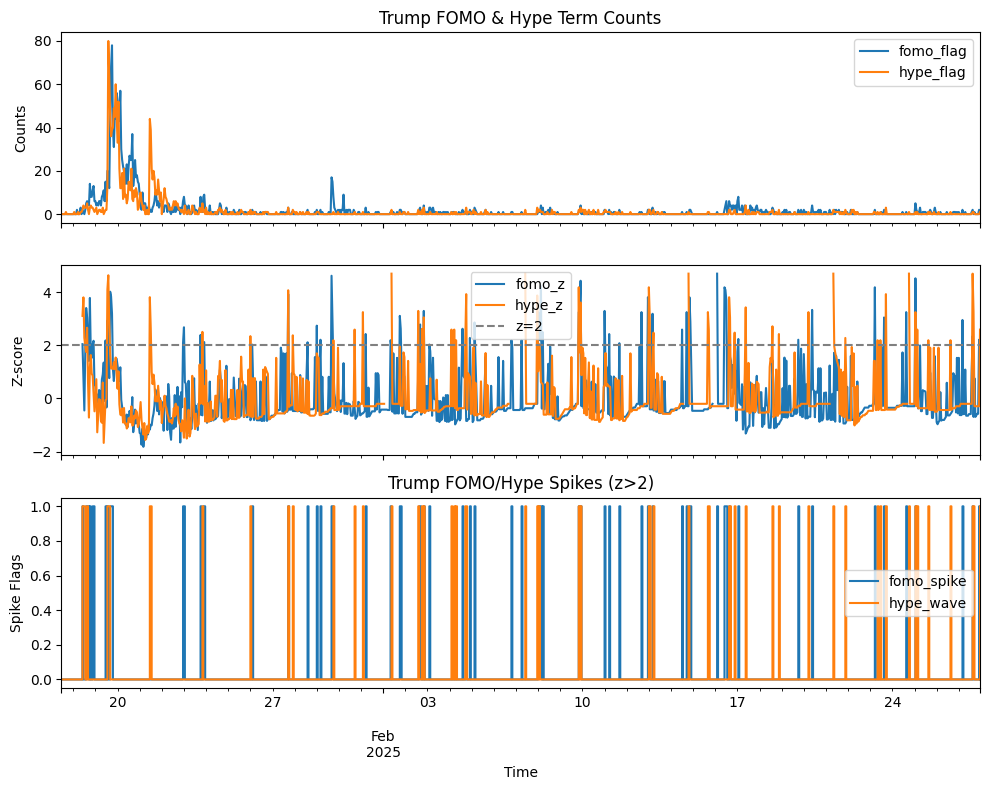

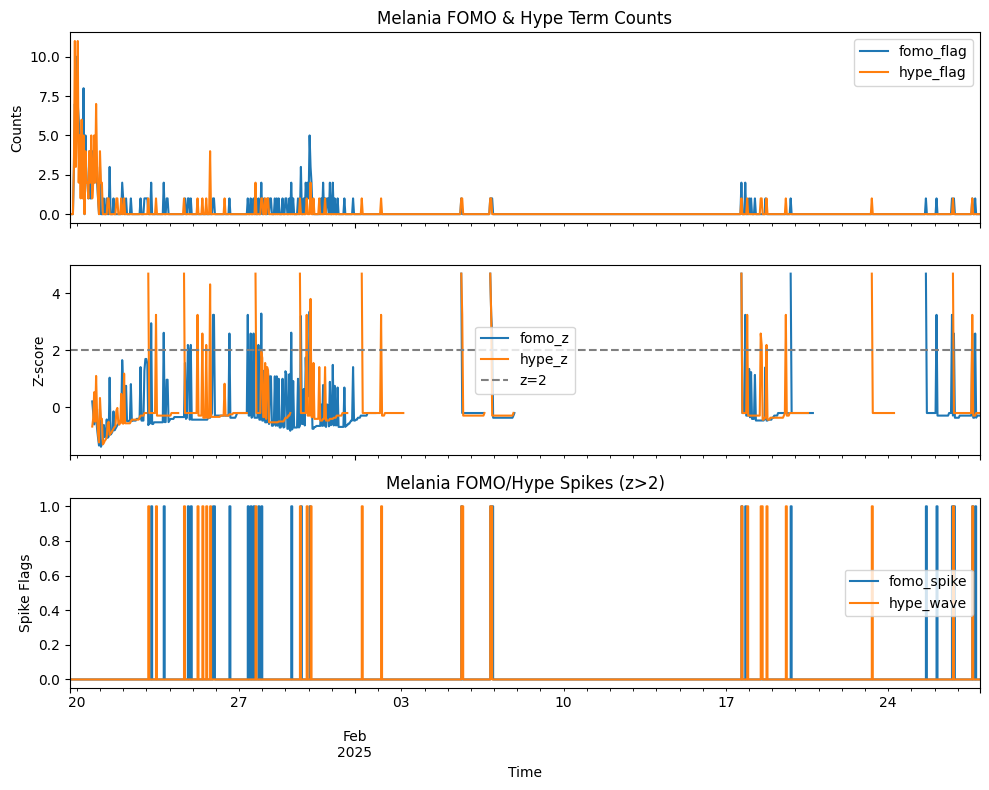

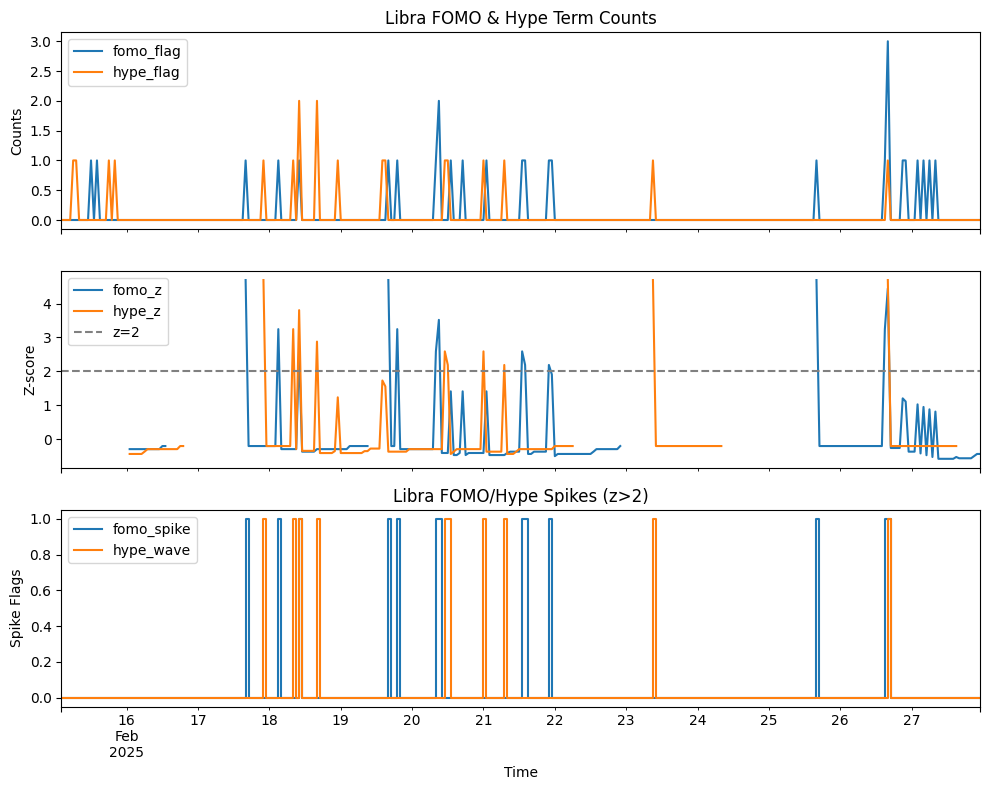

In [8]:
#visualizing the results

for coin, hype_df in zip(['Trump','Melania','Libra'], [hype_trump, hype_melania, hype_libra]):
    #plotting the fomo and hype flags
    fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    hype_df[['fomo_flag','hype_flag']].plot(ax=axes[0])
    axes[0].set_ylabel('Counts')
    axes[0].set_title(f'{coin} FOMO & Hype Term Counts')
    
    #plotting the z-scores
    hype_df[['fomo_z','hype_z']].plot(ax=axes[1])
    axes[1].axhline(2, color='gray', linestyle='--', label='z=2')
    axes[1].set_ylabel('Z-score')
    axes[1].legend()
    
    #plotting the spikes
    hype_df[['fomo_spike','hype_wave']].plot(ax=axes[2], drawstyle='steps-post')
    axes[2].set_ylabel('Spike Flags')
    axes[2].set_title(f'{coin} FOMO/Hype Spikes (z>2)')
    
    plt.xlabel('Time')
    plt.tight_layout()
    plt.show()
